In [1]:
import warnings

import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az

from scipy import stats
from scipy import special

az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)

In [53]:
print(pm.__version__)
print(az.__version__)

3.11.2
0.11.2


In [2]:
az.rcParams["stats.hdi_prob"] = 0.89

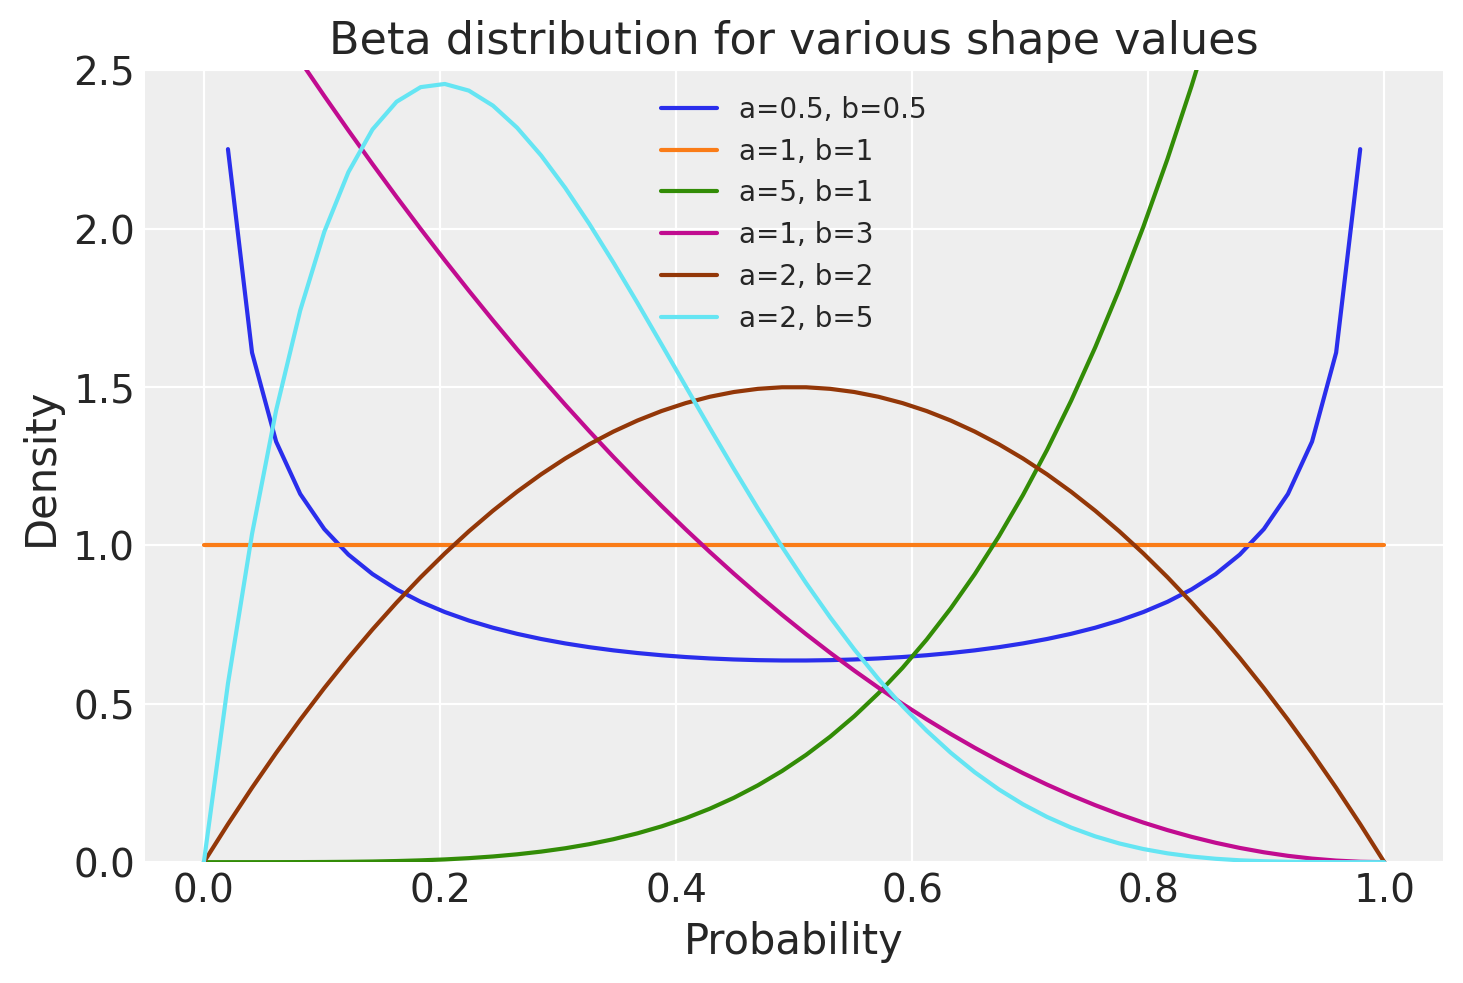

In [3]:
aa = [0.5, 1, 5, 1, 2, 2]
bb = [0.5, 1, 1, 3, 2, 5]
x = np.linspace(0, 1, 50)
for a, b in zip(aa, bb):
    plt.plot(x, stats.beta.pdf(x, a, b), label=f"a={a}, b={b}")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.ylim(0, 2.5)
plt.title("Beta distribution for various shape values")
plt.legend(loc="upper center", fontsize='medium');

In [4]:
admit_df = pd.read_csv('Data/UCBadmit.csv', sep=";")
N = admit_df['applications'].values
gid = pd.factorize(admit_df['applicant.gender'])[0]

In [5]:
with pm.Model() as m12_1:
    a = pm.Normal("a", 0, 1.5, shape=2)
    phi = pm.Exponential("phi", 1)
    theta = pm.Deterministic("theta", phi + 2.0)
    pbar = pm.Deterministic("pbar", pm.math.invlogit(a[gid]))
    A = pm.BetaBinomial("A", pbar*theta, (1.0-pbar)*theta, N, observed=admit_df.admit)
    trace12_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [6]:
az.summary(trace12_1, var_names=["a", "phi", "theta"], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.44,0.41,-1.13,0.19,0.01,0.01,2277.77,1955.83,1.0
a[1],-0.33,0.41,-0.95,0.34,0.01,0.01,2534.34,2433.06,1.0
phi,1.05,0.80,0.00,2.11,0.02,0.01,2047.83,1426.21,1.0
theta,3.05,0.80,2.00,4.11,0.02,0.01,2047.83,1426.21,1.0


In [7]:
diff_a = trace12_1["a"][:, 0] - trace12_1["a"][:, 1]
az.summary({"diff_a": diff_a}, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
diff_a,-0.12,0.58,-1.08,0.75


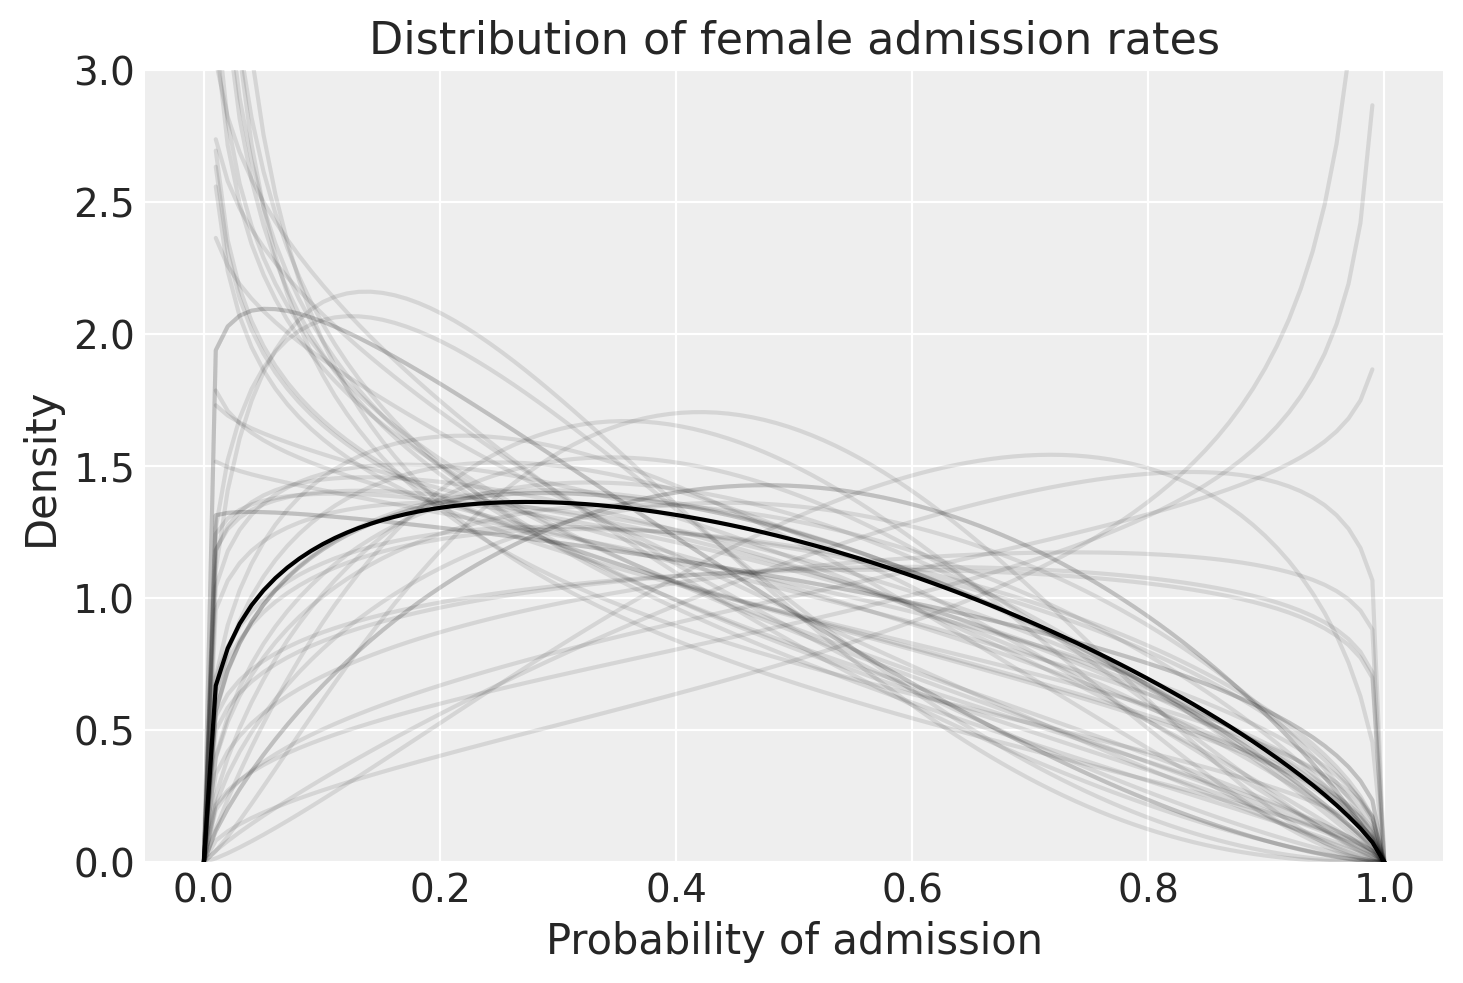

In [8]:
x = np.linspace(0, 1, 100)
pbar_mean = special.expit(trace12_1['a'][:, 1]).mean()
theta_mean = trace12_1['theta'].mean()
plt.plot(x, stats.beta.pdf(x, pbar_mean*theta_mean, (1-pbar_mean)*theta_mean), color='k')
plt.plot(x, stats.beta.pdf(x[:, np.newaxis], 
                           special.expit(trace12_1['a'][:50, 1])*trace12_1['theta'][:50], 
                           (1-special.expit(trace12_1['a'][:50, 1]))*trace12_1['theta'][:50]), color='k', alpha=0.1)
plt.ylim(0, 3)
plt.xlabel("Probability of admission")
plt.ylabel("Density")
plt.title('Distribution of female admission rates');

In [9]:
# Drink 20% of days, average 1 manuscripts per day
prob_drink = 0.2
rate_work = 1
N = 365
drink = np.random.binomial(1, p=prob_drink, size=N)
y = (1-drink)*np.random.poisson(rate_work, size=N)

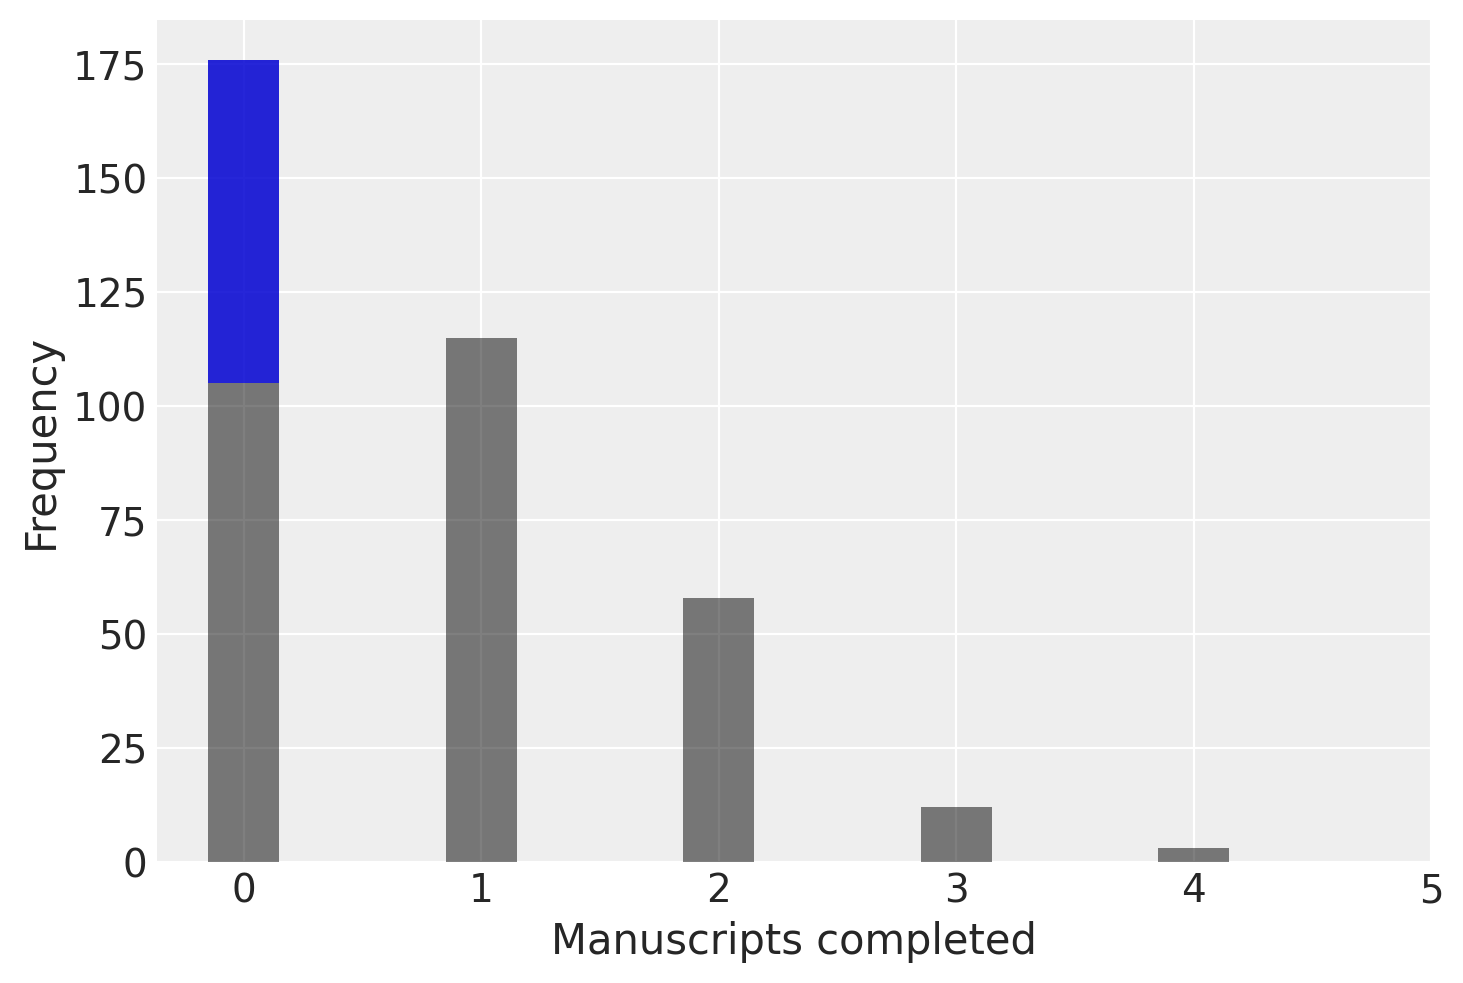

In [10]:
zeros_drink = drink.sum()
zeros_work = (y==0).sum() - zeros_drink
zeros_total = (y==0).sum()
bins = np.arange(y.max() + 1) - 0.5
plt.hist(y, bins=bins, align="mid", rwidth=0.3, color="k", alpha=0.5)
plt.bar(0.0, zeros_drink, bottom=zeros_work, width=0.3, color="b", alpha=0.7)
plt.xticks(bins + 0.5)
plt.xlabel("Manuscripts completed")
plt.ylabel("Frequency");

In [11]:
with pm.Model() as m12_3:
    ap = pm.Normal("ap", -1.5, 1)
    al = pm.Normal("al", 1, 0.5)
    lam = pm.math.exp(al)
    p = pm.math.invlogit(ap)
    yobs = pm.ZeroInflatedPoisson("yobs", 1-p, lam, observed=y)
    trace12_3 = pm.sample(tune=3000)
az.summary(trace12_3, kind="stats", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [al, ap]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 4 seconds.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_5.5%,hdi_94.5%
ap,-2.0,0.56,-2.83,-1.19
al,-0.1,0.08,-0.23,0.04


In [12]:
print(special.expit(trace12_3['ap']).mean())
print(np.exp(trace12_3['al']).mean())

0.1302676751065133
0.909940545789


In [13]:
trolley = pd.read_csv('Data/Trolley.csv', sep=";")
trolley

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9925,ilpon,3,23,98;299,66,1,Graduate Degree,0,1,0,pon,0
9926,ilsha,6,15,98;299,66,1,Graduate Degree,0,1,0,sha,0
9927,ilshi,7,7,98;299,66,1,Graduate Degree,0,1,0,shi,0
9928,ilswi,2,18,98;299,66,1,Graduate Degree,0,1,0,swi,0


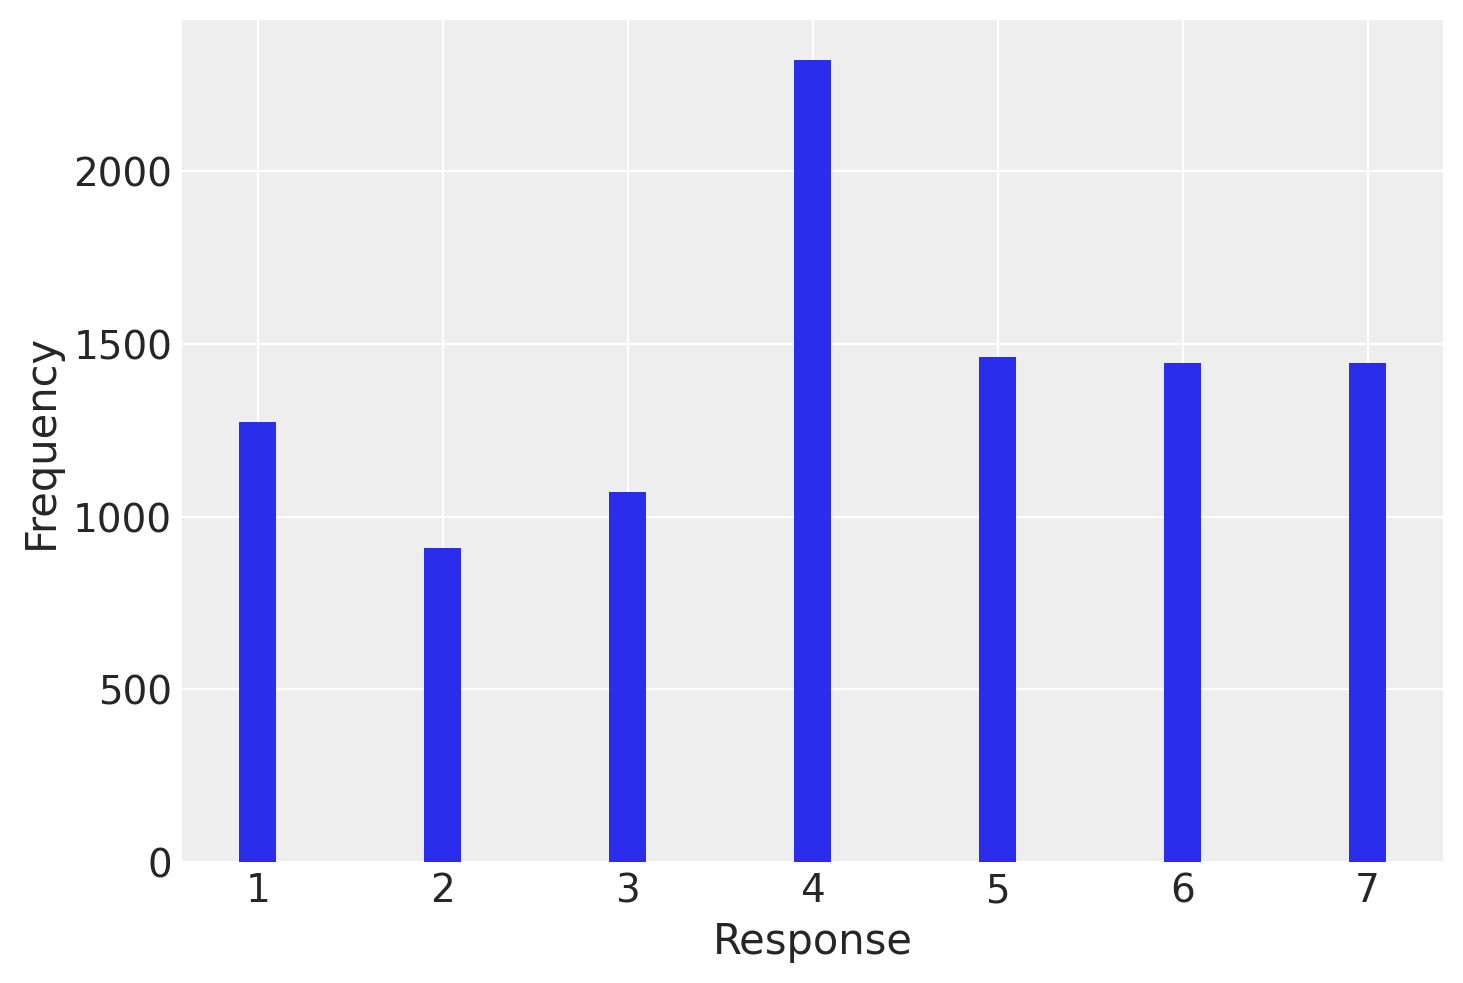

In [19]:
bins = np.arange(trolley.response.max() + 1) + 0.5
plt.hist(trolley.response, rwidth=0.2, bins=bins)
plt.xlabel("Response")
plt.ylabel("Frequency");

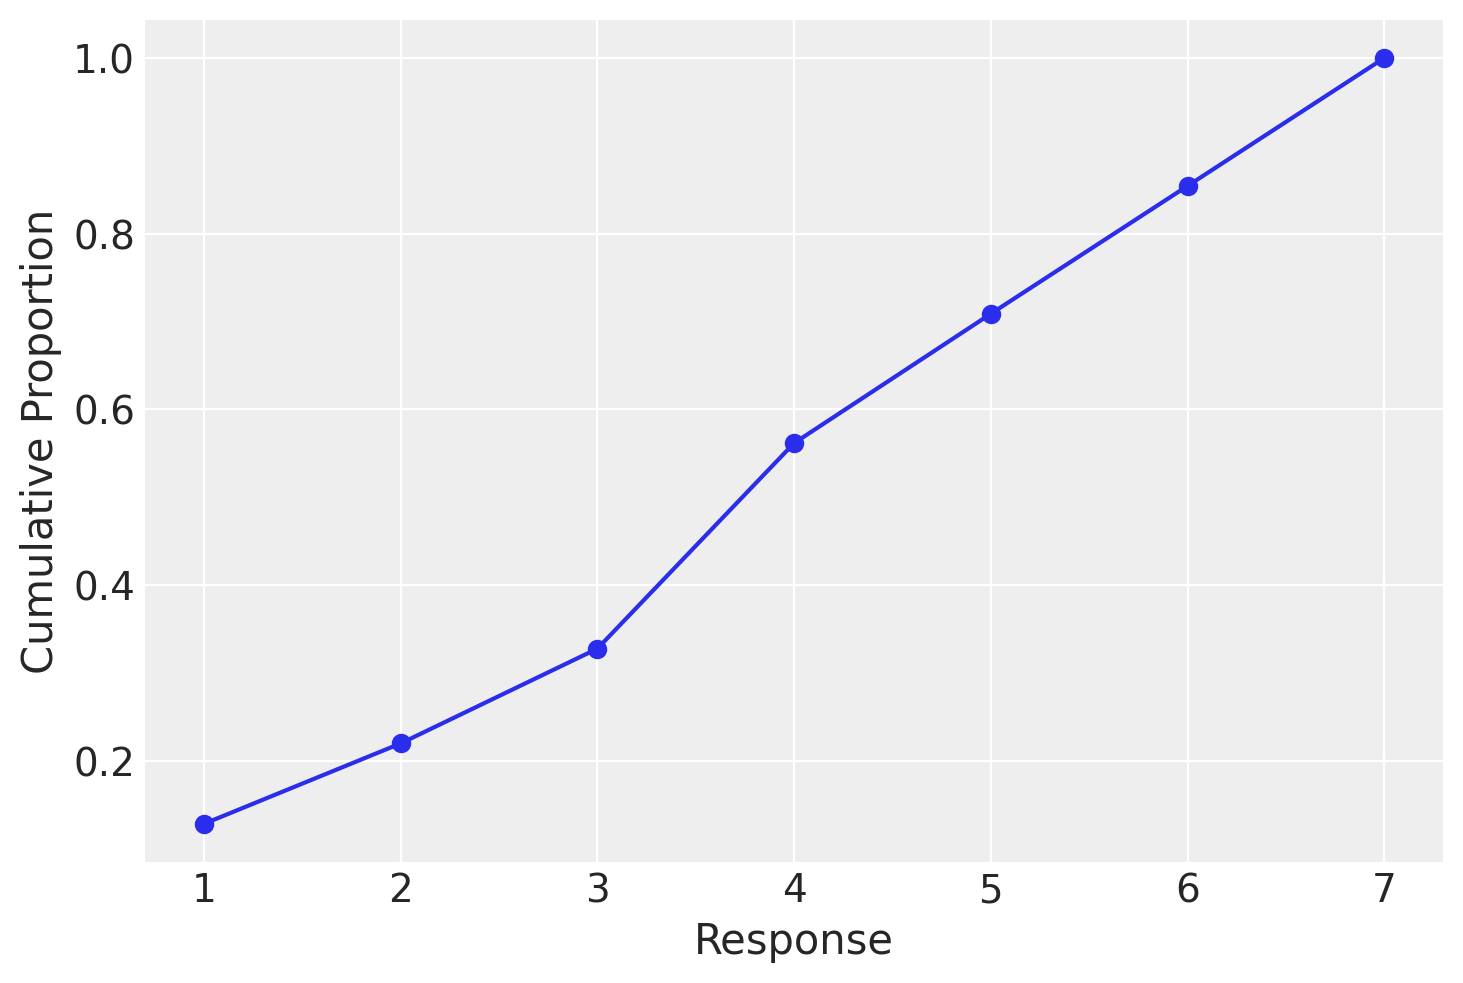

In [44]:
cum_pr_k = trolley.response.value_counts(normalize=True, sort=False).cumsum()
plt.plot(np.arange(1,8), cum_pr_k, '-o')
plt.xlabel('Response')
plt.ylabel('Cumulative Proportion');

Text(0, 0.5, 'log-cumulative-odds')

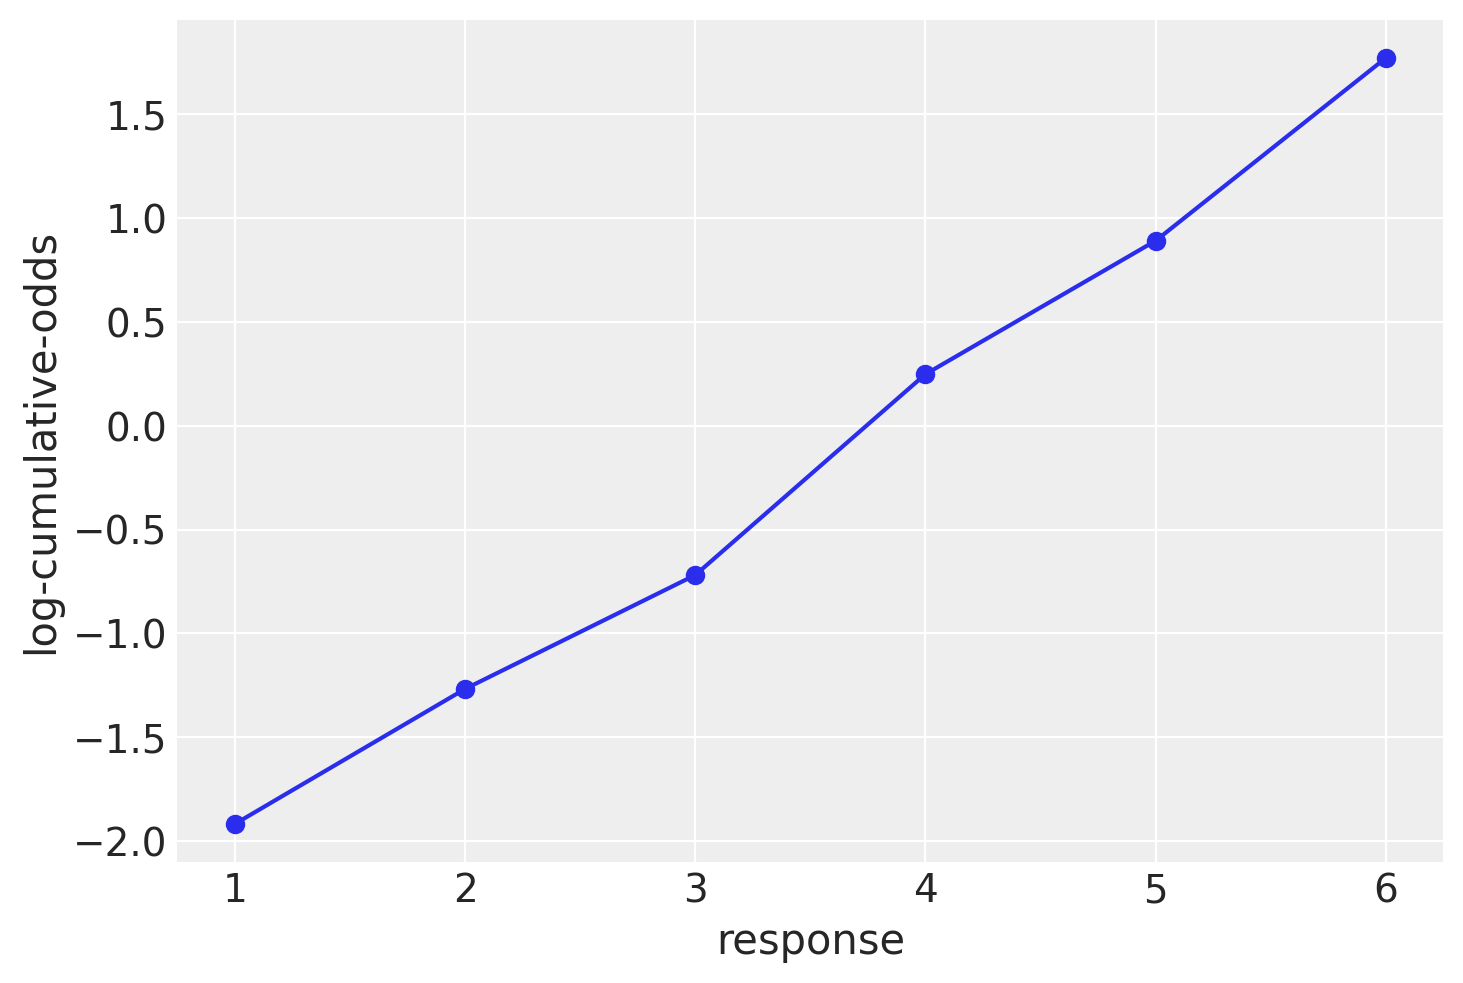

In [46]:
lco = cum_pr_k.apply(special.logit)
plt.plot(np.arange(1,8), lco, '-o')
plt.xlabel('response')
plt.ylabel('log-cumulative-odds')

In [47]:
lco

1   -1.916091
2   -1.266606
3   -0.718634
4    0.247786
5    0.889864
6    1.769381
7         NaN
Name: response, dtype: float64

In [55]:
with pm.Model() as m12_4:
    cutpoints = pm.Normal("cutpoints", 0, 1.5, 
                          transform=pm.distributions.transforms.ordered, 
                          shape=6, testval=np.arange(6)-2.5)
    R = pm.OrderedLogistic("R", 0.0, cutpoints, observed=trolley.response.values - 1)
    trace12_4 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [56]:
az.summary(trace12_4, kind='stats', round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
cutpoints[0],-1.92,0.03,-1.97,-1.87
cutpoints[1],-1.27,0.02,-1.30,-1.23
cutpoints[2],-0.72,0.02,-0.75,-0.68
cutpoints[3],0.25,0.02,0.22,0.28
cutpoints[4],0.89,0.02,0.86,0.93
cutpoints[5],1.77,0.03,1.73,1.82


In [74]:
print(special.expit(trace12_4['cutpoints'].mean(axis=0)).round(3))

[0.128 0.22  0.328 0.562 0.709 0.854]


In [82]:
def ordered_logit_prob(a):
    p = special.expit(a)
    p = np.concatenate(([0.0], p, [1.0]))
    return p[1:] - p[:-1]

In [90]:
pk = ordered_logit_prob(trace12_4['cutpoints'].mean(0))

In [91]:
np.sum(np.arange(1,8)*pk)

4.1990476720815275

In [92]:
pk = ordered_logit_prob(trace12_4['cutpoints'].mean(0) - 0.5)
np.sum(np.arange(1,8)*pk)

4.729458688870175

In [106]:
with pm.Model() as m12_5:
    cutpoints = pm.Normal("cutpoints", 0, 1.5, 
                          transform=pm.distributions.transforms.ordered, 
                          shape=6, testval=np.arange(6)-2.5)
    bA = pm.Normal("bA", 0, 0.5)
    bI = pm.Normal("bI", 0, 0.5)
    bC = pm.Normal("bC", 0, 0.5)
    bIA = pm.Normal("bIA", 0, 0.5)
    bIC = pm.Normal("bIC", 0, 0.5)
    
    A = pm.Data('A', trolley.action.values)
    I = pm.Data('I', trolley.intention.values)
    C = pm.Data('C', trolley.contact.values)
    
    bI = bI + bIA*A + bIC*C
    phi = pm.Deterministic("phi", bA*A + bC*C + bI*I)
    
    reps_obs = pm.OrderedLogistic("reps_obs", phi, cutpoints, observed=trolley.response-1)
    trace12_5 = pm.sample()
    ibdata12_5 = az.from_pymc3(trace12_5)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bIC, bIA, bC, bI, bA, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.


In [107]:
az.summary(trace12_5, kind='stats', var_names=['bA', 'bI', 'bC', 'bIA', 'bIC'], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
bA,-0.47,0.05,-0.55,-0.38
bI,-0.29,0.06,-0.38,-0.20
bC,-0.34,0.07,-0.44,-0.23
bIA,-0.44,0.08,-0.56,-0.31
bIC,-1.24,0.10,-1.40,-1.09


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

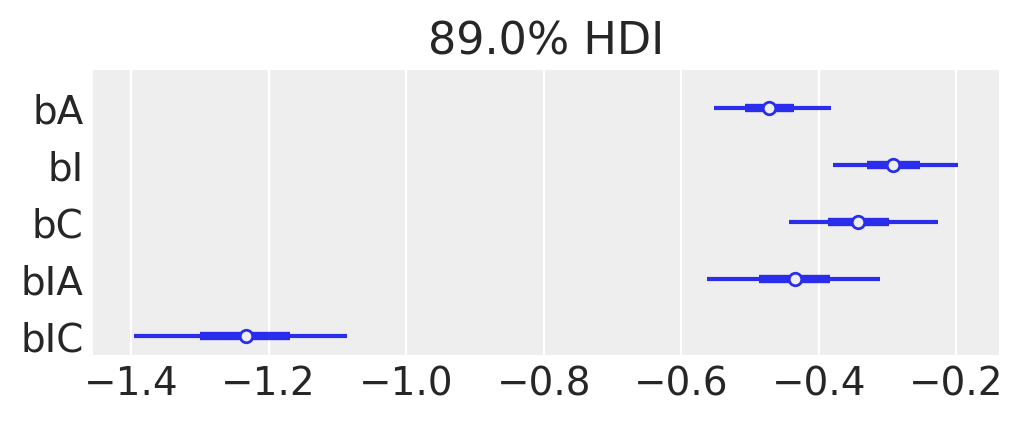

In [111]:
az.plot_forest(ibdata12_5, var_names=['bA', 'bI', 'bC', 'bIA', 'bIC'], figsize=(5,2), combined=True)

In [113]:
trolley.edu.unique()

array(['Middle School', "Bachelor's Degree", 'Some College',
       "Master's Degree", 'High School Graduate', 'Graduate Degree',
       'Some High School', 'Elementary School'], dtype=object)